In [31]:
# Optional for clear plotting on Macs
# %config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with
#  what's causing the warning and simply don't want to see it, we can use the
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

warnings.filterwarnings("ignore")

if not sys.warnoptions:

    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"



In [32]:
# Load libraries
import pandas as pd
from scipy import stats
from plotnine import *
import dame_flame
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pathlib import Path



In [33]:
# Find path
PARENT = "uds-2022-ids-701-team-10"
listing_path = Path(PARENT).parent / "../20_intermediate_files"


In [34]:
# Load dataset
listings2 = pd.read_csv(listing_path/ "final_listings.csv")
listings2 = listings2.drop(columns=["Unnamed: 0"])
listings = listings2.copy()


In [35]:
# T-test on annual revenue across groups
superhosts = listings[listings["host_is_superhost"] == 1]
regularhosts = listings[listings["host_is_superhost"] == 0]
print(superhosts["hotel_room_revenue"].mean() - regularhosts["hotel_room_revenue"].mean())
print(stats.ttest_ind(superhosts["hotel_room_revenue"], regularhosts["hotel_room_revenue"]))


19293.448432430858
Ttest_indResult(statistic=5.464259815709481, pvalue=4.736902751231556e-08)


In [36]:
print(superhosts["number_of_reviews_ltm"].mean() - regularhosts["number_of_reviews_ltm"].mean())
print(stats.ttest_ind(superhosts["number_of_reviews_ltm"], regularhosts["number_of_reviews_ltm"]))

13.325647116094325
Ttest_indResult(statistic=41.66237233587012, pvalue=0.0)


<font color="darkgreen">

From the statistically significant p-value in T-test, it seems that there is a negative effect of superhosts on the annual revenue. We will now rum DAME in order to reduce the bias that may have introduced by confounding variables. 


In [37]:
# Check distribution
print(superhosts.shape)
print(regularhosts.shape)


(5599, 23)
(6985, 23)


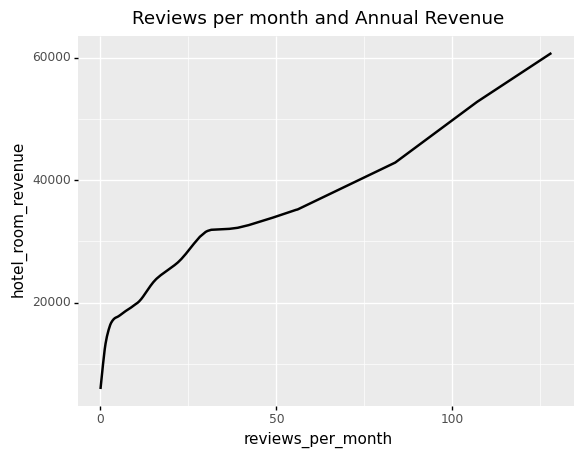

<ggplot: (8785681599025)>

In [38]:
# Check relationship
p = ggplot(listings, aes(x="reviews_per_month", y="hotel_room_revenue")) + geom_smooth(
    method="lowess"
)
p + labs(title="Reviews per month and Annual Revenue")



In [39]:
# Discretize continous variables
listings["bedrooms"] = pd.qcut(listings.bedrooms, 2, labels=False)

listings["host_acceptance_rate"] = pd.qcut(
    listings.host_acceptance_rate, 3, labels=False
)

listings["accommodates"] = listings["accommodates"].astype(int)
listings["accommodates"] = pd.qcut(listings.accommodates, 2, labels=False)

listings["bathrooms_text"] = round(listings["bathrooms_text"].astype(float), 1)
listings["bathrooms_text"] = pd.qcut(listings.bathrooms_text, 2, labels=False)

listings["beds"] = pd.qcut(listings.beds, 2, labels=False)

listings["number_of_reviews_ltm"] = listings["number_of_reviews_ltm"].astype(int)
listings["number_of_reviews_ltm"] = pd.qcut(listings.number_of_reviews_ltm, 5, labels=False)

listings["review_scores_rating"] = listings["review_scores_rating"].astype(int)
listings["review_scores_rating"] = pd.qcut(
    listings.review_scores_rating, 2, labels=False
)

listings["reviews_per_month"] = listings["reviews_per_month"].astype(int)
listings["reviews_per_month"] = pd.qcut(listings.reviews_per_month, 2, labels=False)

listings["other_amenities"] = pd.qcut(listings.other_amenities, 2, labels=False)

listings["host_experience"] = listings["host_experience"].astype(int)
listings["host_experience"] = pd.qcut(listings.host_experience, 2, labels=False)

listings["host_response_rate"] = np.where(listings.host_response_rate == 100, 1, 0)

listings["room_type"] = listings["room_type"].astype("category")
listings["room_type"] = listings["room_type"].cat.codes


listings["state"] = np.where(listings.state == "Florida", 1, 0)

listings["calculated_host_listings_count"] = round(
    listings["calculated_host_listings_count"].astype(int)
)
listings["calculated_host_listings_count"] = np.where(
    listings["calculated_host_listings_count"] == 1,
    0,
    (
        np.where(
            listings["calculated_host_listings_count"] == 2,
            1,
            np.where(listings["calculated_host_listings_count"] == 3, 2, 3,),
        )
    ),
)



In [40]:
listings.sample(5)


,host_id,state,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,room_type,accommodates,...,has_availability,number_of_reviews_ltm,review_scores_rating,instant_bookable,calculated_host_listings_count,reviews_per_month,essentials,other_amenities,hotel_room_revenue,host_experience
11731,390120243,1,0,1,0,0,1,1,0,1,...,1,2,0,0,0,0,1,1,32515.522388,0
628,1896248,0,1,1,0,0,1,1,0,0,...,1,0,0,0,1,0,1,0,0.000000,1
11381,370159974,0,0,1,1,0,1,1,0,0,...,1,0,1,1,0,0,1,0,555.223881,0
10333,275407989,1,0,1,1,1,1,1,2,0,...,1,2,0,0,0,0,1,0,1477.611940,0
7818,135426997,1,3,0,0,0,1,1,2,0,...,1,0,0,0,0,0,1,0,0.000000,0


In [41]:
# Drop unnecessary columns for DAME
listings1 = listings.drop(columns=["host_id", "hotel_room_revenue"])


In [42]:
# Check data types 
listings1.dtypes


state                             int64
host_response_time                int64
host_response_rate                int64
host_acceptance_rate              int64
host_is_superhost                 int64
host_has_profile_pic              int64
host_identity_verified            int64
room_type                          int8
accommodates                      int64
bathrooms_text                    int64
bedrooms                          int64
beds                              int64
has_availability                  int64
number_of_reviews_ltm             int64
review_scores_rating              int64
instant_bookable                  int64
calculated_host_listings_count    int64
reviews_per_month                 int64
essentials                        int64
other_amenities                   int64
host_experience                   int64
dtype: object

In [43]:
# Run DAME
model = dame_flame.matching.DAME(
    repeats=False, verbose=3, want_pe=True, early_stop_iterations=15
)
model.fit(
    listings1,
    treatment_column_name="host_is_superhost",
    outcome_column_name="number_of_reviews_ltm",
)
result = model.predict(listings1)
result


Iteration number:  1
	Number of matched groups formed in total:  1104
	Unmatched treated units:  2682 out of a total of  5599 treated units
	Unmatched control units:  4494 out of a total of  6985 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  5408
	Number of matches made so far:  5408
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  1446
	Unmatched treated units:  2191 out of a total of  5599 treated units
	Unmatched control units:  4014 out of a total of  6985 control units
	Predictive error of covariates chosen this iteration:  1.949018110948301
	Number of matches made in this iteration:  971
	Number of matches made so far:  6379
	In this iteration, the covariates dropped are:  frozenset({'host_acceptance_rate'})
Iteration number:  3
	Number of matched groups formed in total:  1450
	Unmatched treated units:  2185 out of a total of  5599 treated u

,state,host_response_time,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,room_type,accommodates,bathrooms_text,bedrooms,beds,has_availability,review_scores_rating,instant_bookable,calculated_host_listings_count,reviews_per_month,essentials,other_amenities,host_experience
1,0,0,1,0,1,1,2,0,0,0,0,1,0,0,1,0,1,0,1
2,0,1,1,0,1,1,0,1,1,1,1,1,0,0,1,0,1,0,1
3,0,1,1,0,1,1,2,0,0,0,0,1,0,0,0,0,1,0,1
6,0,0,1,2,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1
9,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12569,1,0,1,*,1,1,0,0,0,0,0,1,1,0,1,0,1,0,0
12570,1,0,1,2,1,1,0,0,0,0,0,1,0,1,3,0,1,0,0
12574,1,0,1,2,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0
12582,1,0,1,2,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0


In [44]:
# Check for prediction error
for_pe = pd.DataFrame(
    {"prediction error": model.pe_each_iter, "i": range(2, len(model.pe_each_iter) + 2)}
)
for_pe


,prediction error,i
0,1.949018,2
1,1.949112,3
2,1.949254,4
3,1.949312,5
4,1.949370,6
5,1.949435,7
6,1.949596,8
7,1.949829,9
8,1.949859,10
9,1.949879,11


In [45]:
result.sample(5)


,state,host_response_time,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,room_type,accommodates,bathrooms_text,bedrooms,beds,has_availability,review_scores_rating,instant_bookable,calculated_host_listings_count,reviews_per_month,essentials,other_amenities,host_experience
7314,1,0,1,*,1,1,0,1,1,1,1,1,0,1,3,0,1,0,0
2873,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,1
8832,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,1,1,1,0
8870,0,1,1,2,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0
5107,0,0,1,1,1,*,0,1,1,1,1,1,0,0,3,1,1,1,1


In [46]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    # assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better


In [47]:
# Add weights and annual revenue
listing_dame = get_dataframe(model, result)
listing_dame.head(5)


,state,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,room_type,accommodates,bathrooms_text,...,review_scores_rating,instant_bookable,calculated_host_listings_count,reviews_per_month,essentials,other_amenities,host_experience,match_group,match_group_size,weights
1,0,0,1,0,1,1,1,2,0,0,...,0,0,1,0,1,0,1,861.0,10.0,1.000000
2,0,1,1,0,0,1,1,0,1,1,...,0,0,1,0,1,0,1,837.0,2.0,0.886203
3,0,1,1,0,1,1,1,2,0,0,...,0,0,0,0,1,0,1,696.0,16.0,1.000000
6,0,0,1,2,1,1,1,0,1,0,...,0,1,0,1,1,0,1,363.0,3.0,1.000000
9,0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,1,0,1,38.0,25.0,0.590802


In [48]:
# Run regression
smf.wls("number_of_reviews_ltm ~ C(host_is_superhost) + C(state)", listing_dame).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                              WLS Regression Results                             
=================================================================================
Dep. Variable:     number_of_reviews_ltm   R-squared:                       0.116
Model:                               WLS   Adj. R-squared:                  0.116
Method:                    Least Squares   F-statistic:                     491.8
Date:                   Thu, 07 Apr 2022   Prob (F-statistic):          2.05e-201
Time:                           02:10:15   Log-Likelihood:                -12865.
No. Observations:                   7492   AIC:                         2.574e+04
Df Residuals:                       7489   BIC:                         2.576e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.5564      0.025     61.939      0.000       1.507       1.606
C(host_is_superhost)[T.1]     0.9281      0.031     29.691      0.000       0.867       0.989
C(state)[T.1]                 0.4155      0.035     11.944      0.000       0.347       0.484
==============================================================================
Omnibus:                     1726.111   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              335.723
Skew:                          -0.138   Prob(JB):                     1.25e-73
Kurtosis:                       2.000   Cond. No.                         3.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
print("Average Treatment Effect on Number of Bookings: ", round(dame_flame.utils.post_processing.ATE(matching_object=model), 2))


Average Treatment Effect on Number of Bookings:  0.62


In [50]:
# Recover original values for continous variables
listing_original = listings2.loc[listing_dame.index]
listing_original["weights"] = listing_dame["weights"]


In [51]:
listing_original

,host_id,state,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,room_type,accommodates,...,number_of_reviews_ltm,review_scores_rating,instant_bookable,calculated_host_listings_count,reviews_per_month,essentials,other_amenities,hotel_room_revenue,host_experience,weights
1,3041,California,0,100,37,1,1,1,2,1.0,...,0.0,4.680,0,2.0,0.350,1,17,0.000000,4828.0,1.000000
2,6829,California,1,100,54,0,1,1,0,6.0,...,0.0,4.645,0,2.0,1.215,1,22,0.000000,4707.5,0.886203
3,7830,California,1,100,71,1,1,1,2,2.0,...,11.0,4.870,0,1.0,1.480,1,24,2134.328358,4681.0,1.000000
6,11652,California,0,100,100,1,1,1,0,6.0,...,43.0,4.950,1,1.0,5.350,1,33,7188.059701,4636.0,1.000000
9,19779,California,0,100,0,0,1,1,0,2.0,...,0.0,4.600,0,1.0,0.140,1,3,0.000000,4571.0,0.590802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12569,433161790,Florida,0,100,100,0,1,1,0,4.0,...,1.0,5.000,0,2.0,1.000,1,30,689.552239,31.0,0.886203
12570,433167077,Florida,0,100,100,0,1,1,0,4.0,...,1.0,1.500,1,11.0,1.000,1,28,186.567164,31.0,0.295401
12574,433470670,Florida,0,100,100,0,1,1,0,6.0,...,1.0,5.000,1,1.0,1.000,1,71,3488.059701,29.0,0.063300
12582,435871016,Florida,0,100,100,0,1,0,0,9.0,...,2.0,5.000,1,2.0,2.000,1,61,22925.373134,11.0,0.886203


In [52]:

# Run regression by controlling for all variables
smf.wls(
    "number_of_reviews_ltm ~ C(host_is_superhost) + C(state) + host_response_time + host_response_rate + host_acceptance_rate + C(host_has_profile_pic)\
        + C(host_identity_verified) + C(room_type) + accommodates + bathrooms_text + bedrooms + beds + C(has_availability) +\
        review_scores_rating +  C(instant_bookable) + calculated_host_listings_count + reviews_per_month + C(essentials) + other_amenities + \
        host_experience",
    listing_original,
    weights=listing_original["weights"],
).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              WLS Regression Results                             
=================================================================================
Dep. Variable:     number_of_reviews_ltm   R-squared:                       0.299
Model:                               WLS   Adj. R-squared:                  0.297
Method:                    Least Squares   F-statistic:                     151.7
Date:                   Thu, 07 Apr 2022   Prob (F-statistic):               0.00
Time:                           02:10:18   Log-Likelihood:                -32476.
No. Observations:                   7492   AIC:                         6.500e+04
Df Residuals:                       7470   BIC:                         6.515e+04
Df Model:                             21                                         
Covariance Type:               nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.5055      7.089     -0.212      0.832     -15.402      12.391
C(host_is_superhost)[T.1]          7.4913      0.421     17.792      0.000       6.666       8.317
C(state)[T.Florida]                0.3536      0.493      0.717      0.473      -0.613       1.320
C(host_has_profile_pic)[T.1]       3.2670      5.253      0.622      0.534      -7.031      13.565
C(host_identity_verified)[T.1]     0.4381      0.549      0.799      0.424      -0.637       1.513
C(room_type)[T.1]                 -6.1087     12.496     -0.489      0.625     -30.605      18.387
C(room_type)[T.2]                 -2.3527      0.594     -3.964      0.000      -3.516      -1.189
C(room_type)[T.3]                 -4.6522     12.488     -0.373      0.710     -29.133      19.829
C(instant_bookable)[T.1]           1.5133      0.461      3.283      0.001       0.610       2.417
C(essentials)[T.1]                -1.2696      1.290     -0.984      0.325      -3.799       1.260
host_response_time                -4.1407      0.420     -9.864      0.000      -4.964      -3.318
host_response_rate                -0.0868      0.033     -2.644      0.008      -0.151      -0.022
host_acceptance_rate               0.1664      0.011     14.740      0.000       0.144       0.189
accommodates                       0.3407      0.198      1.721      0.085      -0.047       0.729
bathrooms_text                    -1.2758      0.426     -2.994      0.003      -2.111      -0.440
bedrooms                          -2.2049      0.393     -5.609      0.000      -2.976      -1.434
beds                               0.8676      0.280      3.097      0.002       0.318       1.417
review_scores_rating               1.1442      0.655      1.747      0.081      -0.139       2.428
calculated_host_listings_count    -0.3136      0.049     -6.385      0.000      -0.410      -0.217
reviews_per_month                  1.8438      0.050     36.785      0.000       1.746       1.942
other_amenities                    0.0160      0.018      0.914      0.361      -0.018       0.050
host_experience                    0.0002      0.000      0.825      0.409      -0.000       0.001
==============================================================================
Omnibus:                     2844.873   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55053.034
Skew:                           1.331   Prob(JB):                         0.00
Kurtosis:                      16.011   Cond. No.                     1.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[

In [53]:
# Estimate Conditional effect by Matched Groups
group_size_treated = []
group_size_overall = []
cate_of_group = []

for group in model.units_per_group:
    # find len of just treated units
    df_mmg = listing_original.loc[group]
    treated = df_mmg.loc[df_mmg["host_is_superhost"] == 1]
    group_size_treated.append(len(treated))
    group_size_overall.append(len(group))
    cate_of_group.append(dame_flame.utils.post_processing.CATE(model, group[0]))


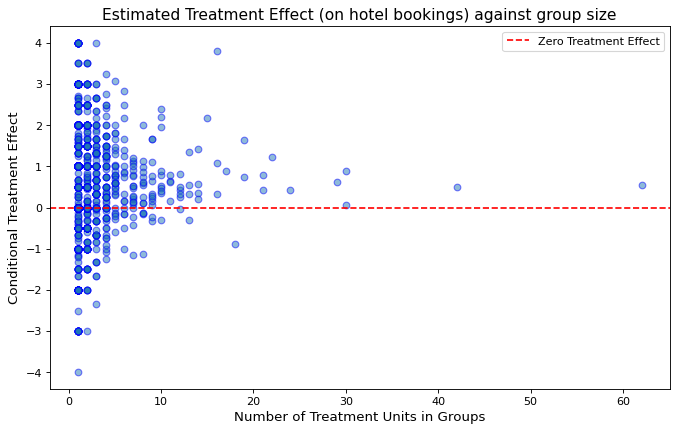

In [54]:
figure(figsize=(10, 6), dpi=80)
plt.scatter(group_size_treated, cate_of_group, alpha=0.5, edgecolors="b")
plt.axhline(y=0.0, color="r", linestyle="--", label="Zero Treatment Effect")
plt.xlabel("Number of Treatment Units in Groups", fontsize=12)
plt.ylabel("Conditional Treatment Effect", fontsize=12)
plt.title(
    "Estimated Treatment Effect (on hotel bookings) against group size", fontsize=14
)
plt.legend()
plt.show()


<font color="darkgreen">

From the plot above, it seems that there is not much can we infer about the conditional effect of "superhosts" on annual revenue from the dataset. Hence, we cannot conclude if there exists any treatment groups for which the impact of "superhosts" on annual revenue is different than the outcomes for other groups. This observation also leads us to the little average treatment effect we found from the dataset.


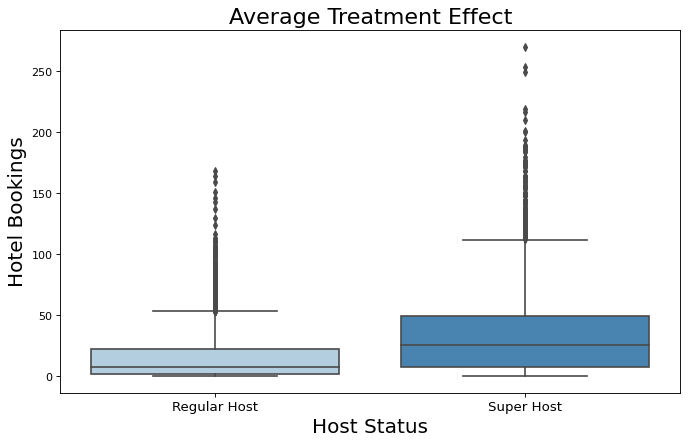

In [55]:
# Visualize box plots for revenue less 2,00,000
ax = figure(figsize=(10, 6), dpi=80)
listing_original['total_bookings'] = listing_original['number_of_reviews_ltm'] * 100/67
sns.boxplot(x="host_is_superhost", y="total_bookings", data=listing_original, palette="Blues")

positions = (0, 1)
labels = ("Regular Host", "Super Host")
plt.xticks(positions, labels, fontsize=12)
plt.title("Average Treatment Effect", fontdict={"fontsize": 20})
plt.xlabel("Host Status", fontdict={"fontsize": 18})
plt.ylabel("Hotel Bookings", fontdict={"fontsize": 18})
plt.show()
